# Material Balances XIV

This lecture continues the discussion of reactor design for systems involving multiple reactions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Example Problem 01: Revisiting Benzene Pyrolysis in a PFR

You are carrying out Benzene Pyrolysis in a Plug Flow Reactor operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
&k_1 = 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&k_2 = 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&K_{C_1} = 0.31\\
&K_{C_2} = 0.48
\end{align*}

If pure benzene is fed into the reactor at 60,000 moles per hour, find the PFR volume required to achieve 50\% conversion of Benzene.  Also, plot the mole fraction of each species as a function of PFR volume.

**Answer**: 403.3 L

### Solution to Example Problem 01

*This is exactly the same as our solution from L22, we are just going to expand consideration of the PFR.*

Even though there are multiple reactions, we approach this problem the same way as usual: we write a material balance on Benzene.

$$\frac{dF_B}{dV} = R_B$$

We generally know that $R_B$ is going to be a complex function of concentrations of all of the species present in this system.  That means we can't solve the above balance on Benzene without also solving balances on Diphenyl, Hydrogen, and Triphenyl *at the same time*, i.e., we have to solve the coupled system of differential equations below:

\begin{align}
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_D}{dV} &= R_D \\
    \frac{dF_H}{dV} &= R_H \\
    \frac{dF_T}{dV} &= R_T \\
\end{align}

So, we've got 4 differential equations that tell us how 4 dependent variables ($F_B$, $F_D$, $F_H$, $F_T$) change as a function of the one independent variable, V.  We can solve this system *if* we can define everything on the right hand sides of the above equations ($R_B$, $R_D$, $R_H$, and $R_T$) in terms of $F_B$, $F_D$, $F_H$, $F_T$, and/or $V$.

We know how to do this!!

Generally:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r1 - r2 \\
    R_D &=  r1 - r2 \\
    R_H &=  r2 + r2 \\
    R_T &=  r2 \\
\end{align}

We next define reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

We define concentrations in terms of molar flowrates:

$$F_j = \frac{F_j}{Q}$$

Which throws a volumetric flowrate, Q, into the mix.  Fortunately, this is a gas phase reaction at low pressure, so we know we can define Q in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

With that, we've defined out system of ODES fully as a function of molar flowrates and reactor volume.  We can solve this numerically using solve_ivp.  See below


In [2]:
def P01(vol, var):
    
    #Dependent variables are all in var
    FB, FD, FH, FT = var
    
    #Constants from problem statement
    T   = 1033    #K
    P   = 1.0     #atm
    R   = 0.08206 #L*atm/mol/K
    k1f = 7.0e5   #L/mol/h
    k2f = 4.0e5   #L/mol/h
    KC1 = 0.31
    KC2 = 0.48
    k1r = k1f/KC1 #L/mol/h
    k2r = k2f/KC2 #L/mol/h=
    
    #total molar flowrate, function of individual molar flowrates
    FTOT = FB + FD + FH + FT
    
    #volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #now that we have concentrations, we define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #With reaction rates, you can define production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #For a PFR, dFj/dV = Rj, so these are our derivatives of FB, FD, FH, FT
    D1   = RB
    D2   = RD
    D3   = RH
    D4   = RT
    
    #return derivatives of each dependent variable w.r.t. volume
    return [D1, D2, D3, D4]

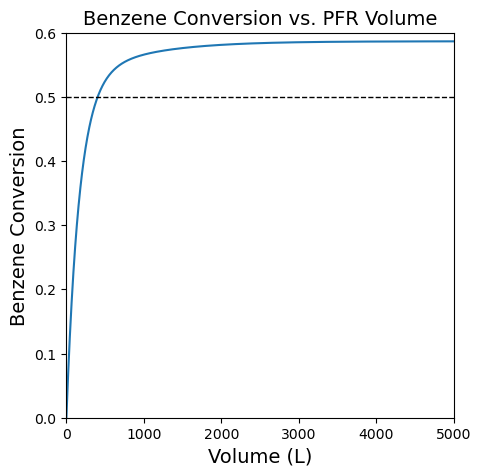

In [3]:
#This cell solves the ODE system (an initial value problem) using solve_ivp
FBf     = 60000 #mol/h
FDf     = 0
FHf     = 0
FTf     = 0

#Solve the problem
vspan   = (0, 5000)
var0    = [FBf, FDf, FHf, FTf]
solP01 = solve_ivp(P01, vspan, var0, atol = 1e-12, rtol = 1e-12)

#Extract data from the solution structure.

#Volumes from the ODE solver
Vout    = solP01.t

#Molar flowrates as a function of volume.
FBout   = solP01.y[0]
FDout   = solP01.y[1]
FHout   = solP01.y[2]
FTout   = solP01.y[3]

#Sum things up to get the total molar flowrate as a function of volume.
FTot_o  = FBout + FDout + FHout + FTout

#Calculate mole fractions as a function of volume.
yBout   = FBout/FTot_o
yDout   = FDout/FTot_o
yHout   = FHout/FTot_o
yTout   = FTout/FTot_o

#Calculate conversion
XBout   = (FBf - FBout)/FBf

#Plot conversion vs. reactor volume.
plt.figure(1, figsize = (5, 5))
plt.title('Benzene Conversion vs. PFR Volume', fontsize = 14)
plt.plot(Vout, XBout)
plt.xlim(0, max(vspan))
plt.ylim(0, 0.6)
plt.hlines(0.5, 0, max(vspan), linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion', fontsize = 14)
plt.show(1)

### Consider Maximixing Diphenyl Production as opposed to Benzene Conversion

We already know (from L21) that we need a 403L PFR in order to achieve 50% conversion of Benzene.  A different question might be what volume *should* the reactor be.  As we discussed in class, that depends on our goal.  If it is to maximize Benzene conversion, then something like a 3000L reactor...but if it is to maximize the production of a certain compound, like diphenyl, we'd make a different choice. In fact, if we really wanted to maximize Diphenyl production, we'd probably want to stick with a reactor volume of about 400L because that is where the mole fraction of diphenyl is at a maximum.  This leads us into a discussion about ***optimization***, which is the third type of numerical method we will use in this course (the first one being ***algebraic equation solvers*** like those in `opt.root()` or `opt.newton()` and the second one being ***ODE/Initial Value Problem solvers*** like those in `solve_ivp()`). We will take a look at numerical methods for optimization (minimization) in Recitation 08 on Thursday. 

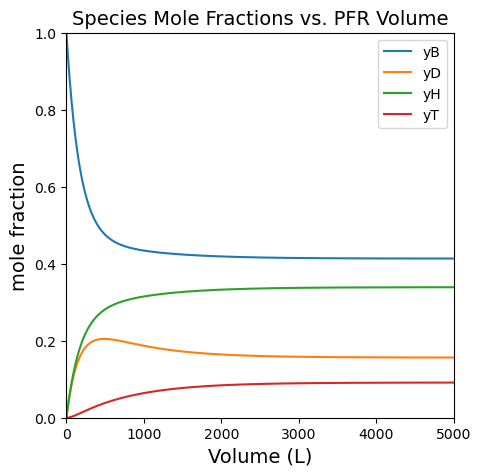

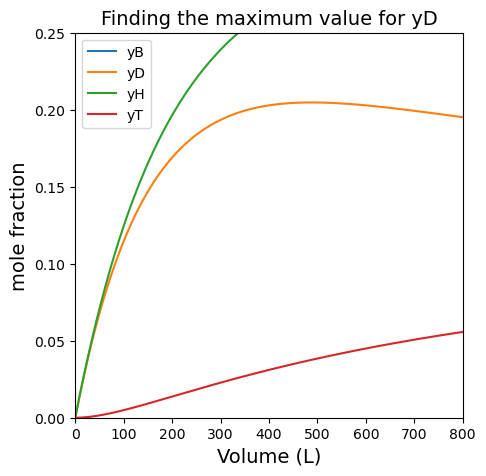

In [4]:
#Plot mole fractions vs. volume
plt.figure(2, figsize = (5, 5))
plt.title('Species Mole Fractions vs. PFR Volume', fontsize = 14)
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show(2)

#Plot mole fractions vs. volume
plt.figure(3, figsize = (5, 5))
plt.title('Finding the maximum value for yD', fontsize = 14)
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, 800)
plt.ylim(0, 0.25)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show(3)

### Using `max()` and `np.argmax()`

For this example, since we've already solved for mole fractions as a function of volume, it is relatively easy to find the PFR volume that would maximize production of diphenyl.

<div class = "alert alert-block alert-warning">
    <b>Note</b>: This is a relatively crude optimization because we are finding the maximum mole fraction of diphenyl that <i>the solver stepped to</i> when solving the ODE system.  The true maximum is probably slightly different from this.
    </div>

In [5]:
yDmax1 = max(yDout)
print(f'The maximum diphenyl mole fraction is {yDmax1:0.3f}. \n')

indexmax = np.argmax(yDout)
yDmax2   = yDout[indexmax]
Vmax2    = Vout[indexmax]
print(f'The maximum diphenyl mole fraction is {yDmax2:0.3f}, which we obtain at a PFR volume of {Vmax2:0.0f}L.')

The maximum diphenyl mole fraction is 0.205. 

The maximum diphenyl mole fraction is 0.205, which we obtain at a PFR volume of 488L.


### Introducing Yield and Selectivity

The benzene pyrolysis examples highlight the fact that conversion alone is not an adequate process specification when we're dealing with multiple reactions.  We also need a way to quantify the amounts of each product that we make.  This is done using two metrics: **Yield** and **Selectivity**.

We define the **yield** as the percentage of our reactant that was converted into a specific product.  

We define the **overall selectivity** as the percentage of consumed reactant that was converted into a specific product.

**Consider A generic pair of reactions**

Let's discuss two reactions.  The first one converts our reactant, A, into a desired product (valuable, non-toxic, beneficial to society somehow, etc).  The second one occurs in parallel and converts our reactant A into something undesirable (toxic, costly to dispose, greenhouse gas, etc).  We would like to establish a general way for discussing the amounts of D and U that are produced in reaction.

\begin{align}
    (1) \qquad \nu_{A1} \, A \longrightarrow \nu_{D1} D \\
    (2) \qquad \nu_{A2} \, A \longrightarrow \nu_{D1} U \\
\end{align}

**Yields**

Consider the yield:  This would be the percentage of our reactant, A, that is converted into each product.  So, for a batch reactor (where we usually work with moles of species), the "yield of D with respect to A" would be defined conceptually as: the number of moles of A converted into species D divided by the initial number of moles of A put into the system.  In equation form, that looks like:

***In a batch reactor***

$$Y_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|N_D}{N_{A0}}$$

Similarly, we would define the yield of U with respect to A as the number of moles of A converted into species U divided by the initial number of moles of A put into the system, i.e.:

$$Y_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|N_U}{N_{A0}}$$

***In a Flow Reactor***

If we were working with a flow reactor, it usually makes more sense to work with molar flowrates instead of number of moles, so we would define the two yields as:

$$Y_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|F_D}{F_{Af}}$$

and

$$Y_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|F_U}{F_{Af}}$$

**Selectivities**

For now, we'll only work with a quantity that we call the "Overall Selectivity," which is defined as the percentage of the *consumed reactant* that was converted into a specific product.  So, at a conceptual level, if I wanted to define the "overall selectivity of D with respect to A," that would be defined as the number of moles of A that were converted to make D divided by the total number of moles of A consumed.  In Equation form:

***In a Batch Reactor***

$$S_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|N_D}{N_{A0} - N_A}$$

And the "overall selectivity of U with respect to A" is given by the number of moles of A converted to make U divided by the total number of moles of A consumed.  

$$S_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|N_U}{N_{A0} - N_A}$$

***In a Flow Reactor***

And, similar to yields, if I'm working with a flow process, I will define these quantities in terms of molar flowrates.

$$S_{D/A} = \frac{\left|\frac{\nu_{A1}}{\nu_{D1}}\right|F_D}{F_{Af} - F_A}$$

and

$$S_{U/A} = \frac{\left|\frac{\nu_{A2}}{\nu_{U2}}\right|F_U}{F_{Af} - F_A}$$

**Fractional Conversion**

These definitions complement the one for fractional conversion:

**Batch Reactor**

$$X_A = \frac{N_{A0} - N_A}{N_{A0}}$$

**Flow Reactor**

$$X_A = \frac{F_{Af} - F_A}{F_{Af}}$$

As a final note:

<div class = "alert alert-block alert-info">
    With the definitions above, fractional conversion, selectivity, and yield will always be between 0 and 1.
    </div>

## Example Problem 02: Benzene Pyrolysis with Yields and Selectivities

You are carrying out Benzene Pyrolysis in a Plug Flow Reactor operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
&k_1 = 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&k_2 = 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&K_{C_1} = 0.31\\
&K_{C_2} = 0.48
\end{align*}

Pure benzene is fed into the reactor at 60,000 moles per hour.  **Plot the overall yield and overall selectivity toward diphenyl (with respect to benzene) as a function of reactor volume.** 

### Solution to Example Problem 02

We solve this essentially the same way as we did Example Problem 01 -- we write the material balances for all species in the reactor, and we solve the resultant coupled system of ODEs using `solve_ivp()`. This part is identical to the solution from L22.

We recognize that solution of the problem using `solve_ivp()` will give us the molar flowrates of Benzene, Diphenyl, Triphenyl, and Hydrogen as a function of reactor volume.  This is enough information for us to calculate yields and selectivity as a function of reactor volume since both of those quantities are defined in terms of molar flowrates for flow reactors.  Specifically:

**Yield of Diphenyl with respect to Benzene**

According to the first reaction, each diphenyl produced will consume two benzenes, so the correct definition for yield according to the equations in the preceding section is:

$$Y_{D/B} = \frac{2F_D}{F_{Bf}}$$

The coefficients are less clear for triphenyl since each triphenyl consumes one diphenyl...which consumes two benzenes.  The easiest way to handle the yield definition for a sequential reaction like this is to add the overall reactions so that we can relate triphenyl directly to benzene:

\begin{align}
   &2B \leftrightarrow D + H \\
   &B + D \leftrightarrow T + H \\
        \hline
    &3B \leftrightarrow T + 2H \\
\end{align}

From that overall equation, it becomes clear that it takes 3 benzenes to make one triphenyl, so the yield definition is:

$$Y_{T/B} = \frac{3F_T}{F_{Bf}}$$

We extend these ideas to the selectivity definitions, which quantify the percentage of consumed reactant that went to produce diphenyl or triphenyl.

Selectivity to diphenyl with respect to benzene:

$$S_{D/B} = \frac{2F_D}{F_{Bf} - F_B}$$

Selectivity to triphenyl with respect to benzene:

$$S_{T/B} = \frac{3F_T}{F_{Bf} - F_B}$$

It is also worth pointing out the the product of fractional conversion and product selectivity (when defined as above) will give the yield to a specific product:

$$Y_{D/B} = X_BS_{D/B} = \frac{F_{Bf} - F_B}{F_{Bf}} \cdot \frac{2F_D}{F_{Bf} - F_B} = \frac{2F_D}{F_{Bf}}$$

$$Y_{T/B} = X_BS_{T/B} = \frac{F_{Bf} - F_B}{F_{Bf}} \cdot \frac{3F_T}{F_{Bf} - F_B} = \frac{3F_T}{F_{Bf}}$$

In [6]:
## Note that we can still use the function that contains the ODE system in P01(vol, var) above. 
## Nothing about the problem has changed other than how we process the ODE solution.

C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_1712\1217347526.py:43: RuntimeWarning: invalid value encountered in divide
  SDB     = FDout*2/(FBf - FBout)
C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_1712\1217347526.py:44: RuntimeWarning: invalid value encountered in divide
  STB     = FTout*3/(FBf - FBout)


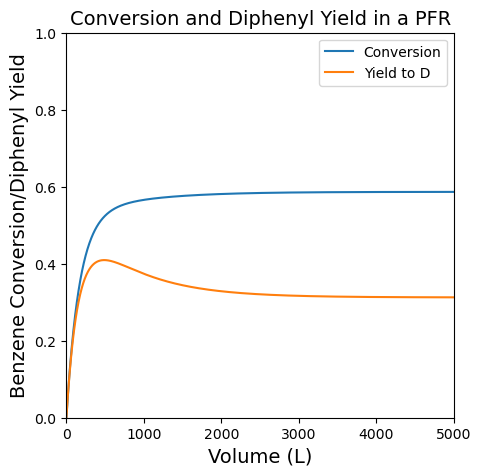

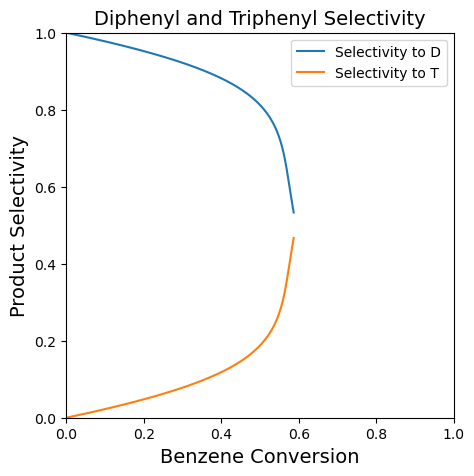

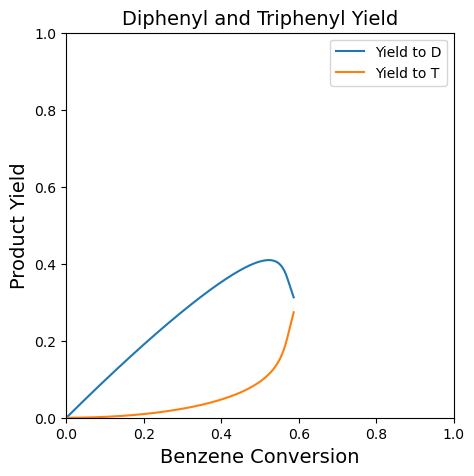

In [7]:
## Commented sections of cell here were solved above; I'm adding just to remind us.
## No need to re-solve.

# #This cell solves the ODE system (an initial value problem) using solve_ivp
# FBf     = 60000 #mol/h
# FDf     = 0
# FHf     = 0
# FTf     = 0

# #Solve the problem
# vspan   = (0, 5000)
# var0    = [FBf, FDf, FHf, FTf]
# solP01 = solve_ivp(P01, vspan, var0, atol = 1e-12, rtol = 1e-12)

# #Extract data from the solution structure.

# #Volumes from the ODE solver
# Vout    = solP01.t

# #Molar flowrates as a function of volume.
# FBout   = solP01.y[0]
# FDout   = solP01.y[1]
# FHout   = solP01.y[2]
# FTout   = solP01.y[3]

# #Sum things up to get the total molar flowrate as a function of volume.
# FTot_o  = FBout + FDout + FHout + FTout

# #Calculate mole fractions as a function of volume.
# yBout   = FBout/FTot_o
# yDout   = FDout/FTot_o
# yHout   = FHout/FTot_o
# yTout   = FTout/FTot_o

# #Calculate conversion
# XBout   = (FBf - FBout)/FBf

#Calculate diphenyl/triphenyl yield
YDB     = FDout*2/FBf
YTB     = FTout*3/FBf

#Calculate diphenyl selectivity
SDB     = FDout*2/(FBf - FBout)
STB     = FTout*3/(FBf - FBout)

#Plot yield, selectivity, conversion vs. reactor volume.
plt.figure(1, figsize = (5, 5))
plt.title('Conversion and Diphenyl Yield in a PFR', fontsize = 14)
plt.plot(Vout, XBout, label = 'Conversion')
plt.plot(Vout, YDB, label = 'Yield to D')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion/Diphenyl Yield', fontsize = 14)
plt.legend()
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.title('Diphenyl and Triphenyl Selectivity', fontsize = 14)
plt.plot(XBout, SDB, label = 'Selectivity to D')
plt.plot(XBout, STB, label = 'Selectivity to T')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Benzene Conversion', fontsize = 14)
plt.ylabel('Product Selectivity', fontsize = 14)
plt.legend()
plt.show(2)

plt.figure(3, figsize = (5, 5))
plt.title('Diphenyl and Triphenyl Yield', fontsize = 14)
plt.plot(XBout, YDB, label = 'Yield to D')
plt.plot(XBout, YTB, label = 'Yield to T')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Benzene Conversion', fontsize = 14)
plt.ylabel('Product Yield', fontsize = 14)
plt.legend()
plt.show(3)

### Finding the value and location of the maximum diphenyl yield

We'll use `max()` and `np.argmax()` as above to get a crude approximation of the maximum, and we'll refine that a bit by creating an interpolating polynomial that returns Volume as a function of benzene yield.  We'll use that with `opt.minimize_scalar()` to find the location of the optimum.  We'll cover this in more detail in Recitation 08.

In [8]:
YDBmax1 = max(YDB)
print(f'The maximum diphenyl yield is approximately {YDBmax1:0.3f}. \n')

indexmax = np.argmax(YDB)
YDBmax2   = YDB[indexmax]
Vmax2    = Vout[indexmax]
print(f'The maximum diphenyl yield is {YDBmax2:0.3f}, which we obtain at a PFR volume of {Vmax2:0.0f}L. \n')

YvVol = interp1d(Vout, YDB)
objtemp = lambda V: -1*YvVol(V)
opt_answer = opt.minimize_scalar(objtemp)
print(opt_answer)
print(f'The maximum yield is {-1*opt_answer.fun:3.3f} at a PFR volume of {opt_answer.x:3.0f}L')

The maximum diphenyl yield is approximately 0.409. 

The maximum diphenyl yield is 0.409, which we obtain at a PFR volume of 488L. 

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.40944518998777024
       x: 487.9055799004276
     nit: 22
    nfev: 29
The maximum yield is 0.409 at a PFR volume of 488L


## Example Problem 03

**This is a slightly modified version of Example 8.4 from Fogler**

The following pair of liquid-phase reactions occur in series. Each reaction is first order in its reactant.

\begin{align}
    A &\longrightarrow B\\
    B &\longrightarrow C \\
\end{align}

By "series" or "sequential" reactions we mean that a product of the first reaction is a reactant in a second reaction, and so on. These are very common systems in Chemical Reaction Engineering -- especially in the petrochemical industry, where we often make reactive things from inert alkanes.  Quite often, the reactive things we make then react away to form things we don't want.  Selectivity control in series reactions requires careful attention to operating conditions and reaction times (space times for flow reactors).

You carry out these reactions in a CSTR operating at steady state.  You may assume the density of the fluid does not change with reaction and so the inlet volumetric flowrate is equal to the outlet volumetric flowrate.  You have the following data available:

\begin{align}
    k_1 &= 0.5 \ \textrm{h}^{-1} \\
    k_2 &= 0.2 \ \textrm{h}^{-1} \\
    C_{Af} &= 20 \ \textrm{mol} \ \textrm{L}^{-1}
\end{align} 

Find the **space time** required to maximize the **yield** of B (with respect to A) in this CSTR.

### Solution to Example 03

#### Balance on A

To get yields, selectivities, and conversions, we need to write material balances on all species.  This allows us to determine the exit molar flowrates of all species.  Starting with a balance on A:

$$0 = F_{A,f} - F_A + R_AV$$

We aren't given a ton of information except for the feed concentration of A.  Presumably, the feed concentrations of B and C are both zero.  We are also told we want to work with a space time, which is defined for a CSTR as:

$$\tau = \frac{V}{Q_f}$$

I'm going to convert my balance so that it is written in terms of concentration and space time instead of molar flowrate and volume. I can express molar flowrates in terms of concentrations and volumetric flowrates:

$$0 = C_{A,f}Q_f - C_AQ + R_AV$$

We know the intensive production rate of A:

$$R_A = -r_1$$

Since the reactions are first order in the reactant:

$$r_1 = k_1C_A$$

Making these substitutions, we find:

$$0 = C_{A,f}Q_f - C_AQ - k_1C_AV$$

We are told that we can assume constant density in this system, which means (at steady state)

$$Q = Q_f$$

Thus:

$$0 = C_{A,f}Q_f - C_AQ_f - k_1C_AV$$

Dividing by $Q_f$, we express the balance in terms of a space time and concentrations.

$$0 = C_{A,f} - C_A - k_1C_A\tau$$

And we can solve this for $C_A$, the exit concentration of A from the CSTR:

$$C_A = \frac{C_{A,f}}{1 + k_1\tau}$$

This is an important result.  It gives us the exit concentration of A as a function of space time. Now we move on to a balance on B:

#### Balance on B

$$0 = F_{B,f} - F_B + R_BV$$

We can replace molar flowrates with the product of concentration and volumetric flowrate, noting again that $Q = Q_f$ for this problem:

$$0 = C_{B,f}Q_f - C_BQ_f + R_BV$$

We can define the intensive production rate of B, $R_B$:

$$R_B = r_1 - r_2$$

We know the reactions are both first order in their reactant, so:

$$R_B = k_1C_A - k_2C_B$$

And we can substitute this into the material balance:

$$0 = C_{B,f}Q_f - C_BQ_f + (k_1C_A - k_2C_B)V$$

Dividing through by $Q_f$:

$$0 = C_{B,f} - C_B + (k_1C_A - k_2C_B)\tau$$

Noting that $C_{B,f} = 0$:

$$0 = C_B + (k_1C_A - k_2C_B)\tau$$

And we can solve this for $C_B$:

$$C_B = \frac{k_1C_A\tau}{1 + k_2 \tau}$$

The above is expressed in terms of $C_A$.  We can substitute that expression in to get:

$$C_B = \frac{k_1C_{A,f}\tau}{(1+k_1\tau)(1+k_2\tau)}$$

This is another important equation as it gives us $C_B$ as a function of $\tau$.

#### Balance on C

Technically, we don't need this to solve for yield/selectivity to B, but I'm curious to see how it behaves, so we'll go ahead and write a balance on C:

$$0 = F_{C,f} - F_C + R_CV$$

Converting to a function of concentration:

$$0 = C_{C,f}Q_f - C_CQ_f + R_CV$$

Defining the production rate for C:

$$R_C = r_2 = k_2C_B$$

We get:

$$0 = C_{C,f}Q_f - C_CQ_f + k_2C_BV$$

Dividing by $Q_f$:

$$0 = C_{C,f} - C_C + k_2C_B\tau$$

Noting that $C_f = 0$:

$$0 = - C_C + k_2C_B\tau$$

Which we can solve for $C_C$:

$$C_C = k_2C_B\tau$$

And we can substitute the expression for $C_B$ here to get:

$$C_C = \frac{k_1k_2C_{A,f}\tau^2}{(1+k_1\tau)(1+k_2\tau)}$$

There we have our concentrations expressed as 3 functions of tau.  These are developed as lambda functions below, which are plotted as a function of tau.


In [9]:
k1 = 0.5 #1/h
k2 = 0.2 #1/h
CAf = 20 #mol/L

CA = lambda tau: CAf/(1 + k1*tau)
CB = lambda tau: k1*CAf*tau/(1+k1*tau)/(1+k2*tau)
CC = lambda tau: k1*k2*CAf*tau**2/(1+k1*tau)/(1+k2*tau)

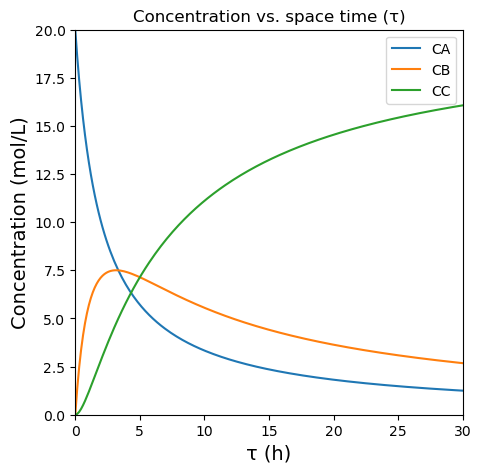

In [10]:
tauset = np.linspace(0, 30, 200)
plt.figure(1, figsize = (5, 5))
plt.plot(tauset, CA(tauset), label = 'CA')
plt.plot(tauset, CB(tauset), label = 'CB')
plt.plot(tauset, CC(tauset), label = 'CC')
plt.title('Concentration vs. space time (τ)', fontsize = 12)
plt.xlabel('τ (h)', fontsize = 14)
plt.ylabel('Concentration (mol/L)', fontsize = 14)
plt.xlim(0, max(tauset))
plt.ylim(0, 20)
plt.legend()
plt.show(1)

### Definining Conversion, Yield, and Selectivity

With the concentrations of each species defined, we can now consider Conversion, Yields and Selectivities. 

#### Conversion

We define the fractional conversion of A as:

$$X_A = \frac{F_{A,f} - F_A}{F_{A,f}}$$

Although we have no way to solve for molar flowrates (since Q is unknown), we can express them in terms of concentrations, noting symbolically that $Q = Q_f$.

$$X_A = \frac{C_{A,f}Q_f - C_AQ_f}{C_{A,f}Q_f}$$

We can factor and cancel the volumetric flowrate, giving us the result below, which is always true for a constant density fluid:

$$X_A = \frac{C_{A,f} - C_A}{C_{A,f}}$$

#### Yields

For a CSTR, we would generally define the yield of B with respect to A as:

$$Y_{B/A} = \frac{F_B\left|\frac{\nu_{A1}}{\nu_{B1}}\right|}{F_{A,f}}$$

Which simplfies for this problem to:

$$Y_{B/A} = \frac{F_B}{F_{A,f}}$$

We actually don't know the molar flowrates since we don't know the size (Q, V) of this system, but we can express these in terms of concentrations, noting that since density is constant $Q = Q_f$:

$$Y_{B/A} = \frac{C_BQ_f}{C_{A,f}Q_f}$$

This reduces to:

$$Y_{B/A} = \frac{C_B}{C_{A,f}}$$

When we go to calculate a yield of C with respect to A, we have to note that by summing the two reactions, we can get the overall stoichiometry of converting A into C:

$$A \longrightarrow C$$

With that, we can use a similar approach to that above to define the yield to C in terms of concentrations:

$$Y_{C/A} = \frac{C_B}{C_{A,f}}$$

#### Selectivities

We can define the selectivity of species B with respect to A:

$$S_{B/A} = \frac{F_B\left|\frac{\nu_{A1}}{\nu_{B1}}\right|}{F_{A,f} - F_A}$$

Substituting stoichiometric coefficients, expressing in terms of concentrations, and noting that $Q = Q_f$:

$$S_{B/A} = \frac{C_BQ_f}{C_{A,f}Q_f - C_AQ_f}$$

Factoring and cancelling the volumetric flowrate (which we can do in cases where it is constant):

$$S_{B/A} = \frac{C_B}{C_{A,f} - C_A}$$

You can follow similar steps to define a selectivity to species C with respect to the reactant A:

$$S_{C/A} = \frac{C_C}{C_{A,f} - C_A}$$

We'll write lambda functions for each of these; note that I'm re-using my concentration functions defined above.

In [11]:
YB = lambda tau: CB(tau)/CAf
YC = lambda tau: CC(tau)/CAf
SB = lambda tau: CB(tau)/(CAf - CA(tau))
SC = lambda tau: CC(tau)/(CAf - CA(tau))
XA = lambda tau: (CAf - CA(tau))/CAf

[[       nan        nan]
 [0.97073171 0.02926829]
 [0.94312796 0.05687204]
 [0.91705069 0.08294931]
 [0.89237668 0.10762332]]


C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_1712\3616170257.py:3: RuntimeWarning: invalid value encountered in divide
  SB = lambda tau: CB(tau)/(CAf - CA(tau))
C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_1712\3616170257.py:4: RuntimeWarning: invalid value encountered in divide
  SC = lambda tau: CC(tau)/(CAf - CA(tau))


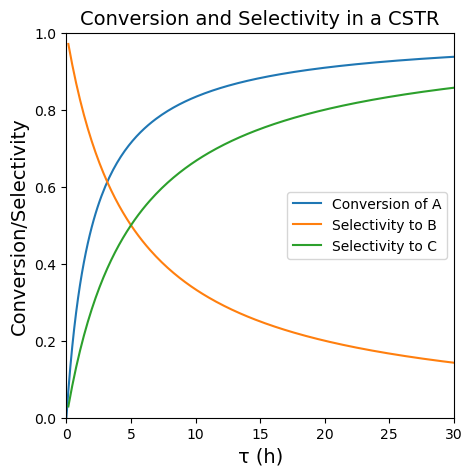

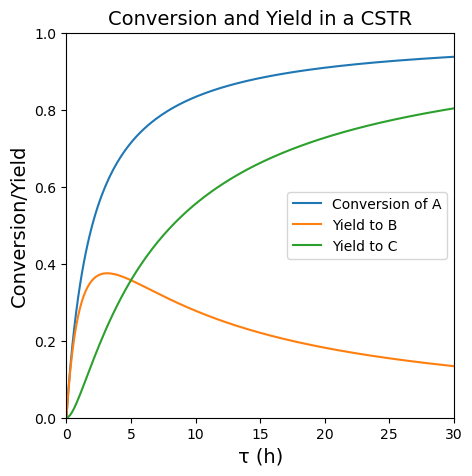

In [12]:
#This just prints out the first few selectivities to show the NAN ("not a number") error
print(np.array([SB(tauset)[0:5], SC(tauset)[0:5]]).T) 

plt.figure(1, figsize = (5, 5))
plt.title('Conversion and Selectivity in a CSTR', fontsize = 14)
plt.plot(tauset, XA(tauset), label = 'Conversion of A')
plt.plot(tauset, SB(tauset), label = 'Selectivity to B')
plt.plot(tauset, SC(tauset), label = 'Selectivity to C')
plt.xlabel('τ (h)', fontsize = 14)
plt.ylabel('Conversion/Selectivity', fontsize = 14)
plt.xlim(0,30)
plt.ylim(0,1)
plt.legend()
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.title('Conversion and Yield in a CSTR', fontsize = 14)
plt.plot(tauset, XA(tauset), label = 'Conversion of A')
plt.plot(tauset, YB(tauset), label = 'Yield to B')
plt.plot(tauset, YC(tauset), label = 'Yield to C')
plt.xlabel('τ (h)', fontsize = 14)
plt.ylabel('Conversion/Yield', fontsize = 14)
plt.xlim(0,30)
plt.ylim(0,1)
plt.legend()
plt.show(2)

### Maximizing the Yield of B

An important question is clearly what space time do we need to use to maximize the yield to species B (the intermediate in the series reaction).  From the graph of Yield vs. tau, we can see this occurs at a space time of about 3 hours.  To get more precise, we can either solve it analytically by taking a derivative of $Y_{B/A}$ with respect to tau; after some calculus and algebra, we get:

$$\frac{dY_{B/A}}{d\tau} = \frac{k_1(1 + k_1\tau)(1 + k_2\tau) - k_1\tau\left[k_1(1 + k_2\tau) + k_2(1 + k_1\tau)\right]}{\left[(1 + k_1\tau)(1+k_1\tau)\right]^2}$$

To find the optimum value of tau, we solve the following expression for $\tau$:

$$0 = \frac{k_1(1 + k_1\tau)(1 + k_2\tau) - k_1\tau\left[k_1(1 + k_2\tau) + k_2(1 + k_1\tau)\right]}{\left[(1 + k_1\tau)(1+k_1\tau)\right]^2}$$

I did this by hand to find:

$$\tau_{\textrm{opt}} = \sqrt{\frac{1}{k_1k_2}}$$ 

Which we can plug into a calculator to get:

$$\tau_{\textrm{opt}} = 3.16 \ \textrm{h}$$ 

Or, you know, we could just create an objective function (return negative yield of B at a specific volume) and minimize that with an optimization routine.  See below.  You get the same answer.

In [13]:
obj    = lambda tau: -1*YB(tau) #this objective function returns -1*YB for a given value of tau
optsol = opt.minimize_scalar(obj) #this varies tau until we hit minimum value of -1*YB
print(optsol, '\n')

print(f'The maximum yield to species B is {-1*optsol.fun:3.2f} which occurs at a space time of {optsol.x:3.2f} hours')

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.3752470442573563
       x: 3.162277615990361
     nit: 11
    nfev: 16 

The maximum yield to species B is 0.38 which occurs at a space time of 3.16 hours
